In [1]:

# Imporing required Packages/Modules
import os
import tensorflow as tf
import datetime
import numpy as np # For array-related manipulations
import pandas as pd # For DataFrame-related operations 
import matplotlib.pyplot as plt # Useful for graph plotting
import seaborn as sns # Another easy graph module
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # Will be used for model evaluation
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential, load_model # Base class for most Neural Networks
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn.svm import SVC
from keras.layers import Input, Conv2D, MaxPool2D, Dense
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from tensorflow.keras.layers import Concatenate, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import time



In [2]:
data_dir = r'D:\New_Fourth_Year\projectDesignGit\pestInfestationSeverityLevel\Sugarcane Leaf Disease Split No Background'

Train_Data_Generator = ImageDataGenerator(featurewise_center=False,
                                    rescale=1./255,
                                    #rotation_range=30,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,)

Test_Data_Generator = ImageDataGenerator(
                                    rescale=1./255)

train_set = Train_Data_Generator.flow_from_directory(directory=data_dir + '/train',
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True)


val_set = Test_Data_Generator.flow_from_directory(directory=data_dir + '/validation',
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True)


Found 1845 images belonging to 5 classes.
Found 465 images belonging to 5 classes.


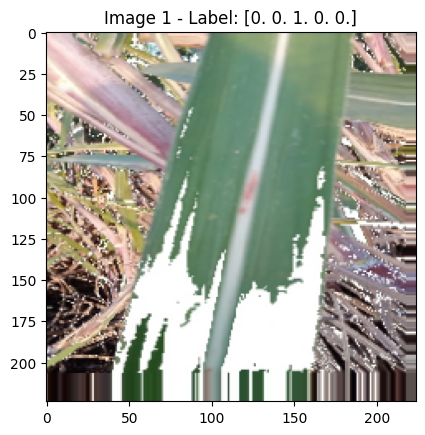

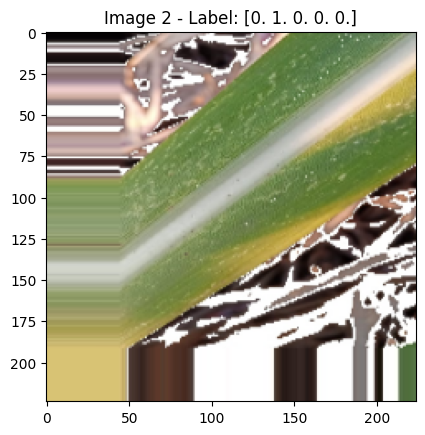

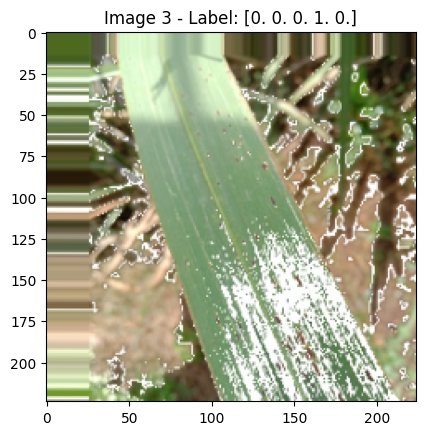

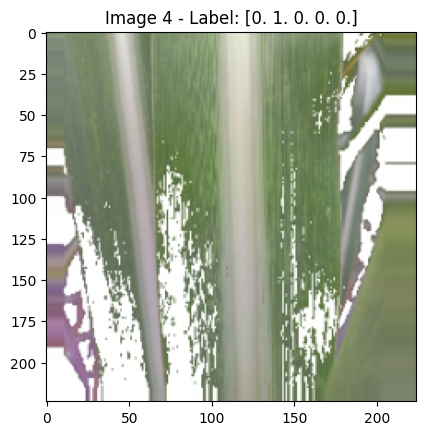

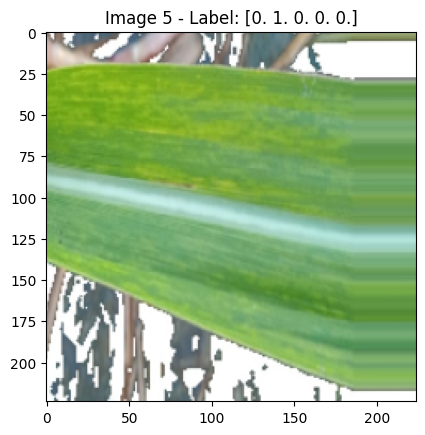

In [3]:
import matplotlib.pyplot as plt

# Extract the images and labels from the batch
images, labels = next(train_set)

# Output the first five images
for i in range(5):
    # Display the current image and label using matplotlib
    plt.imshow(images[i])
    plt.title(f"Image {i + 1} - Label: {labels[i]}")
    plt.show()


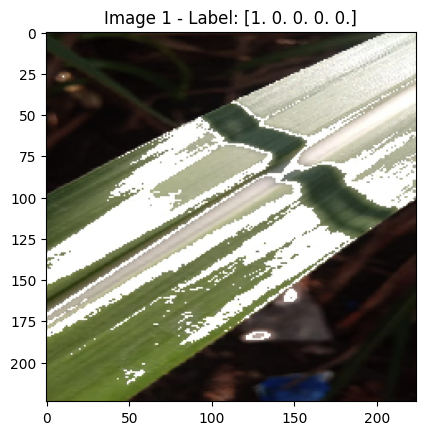

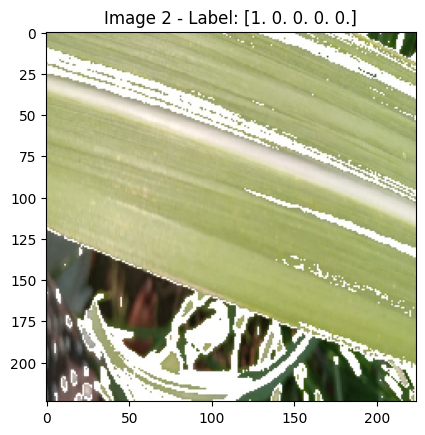

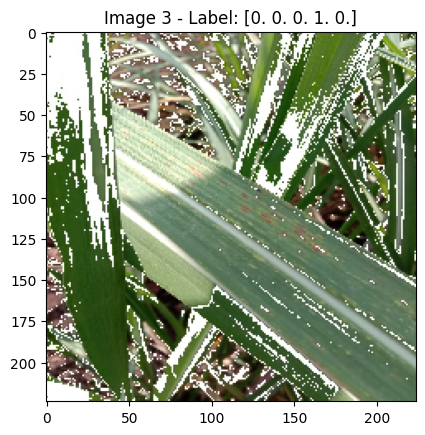

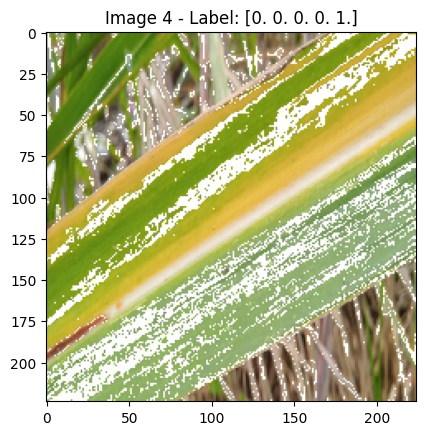

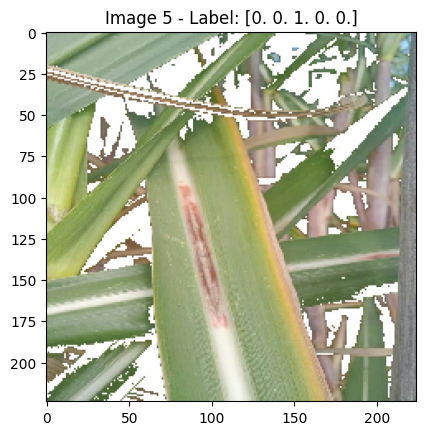

In [4]:
import matplotlib.pyplot as plt

# Extract the images and labels from the batch
images, labels = next(val_set)

# Output the first five images
for i in range(5):
    # Display the current image and label using matplotlib
    plt.imshow(images[i])
    plt.title(f"Image {i + 1} - Label: {labels[i]}")
    plt.show()


In [5]:
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Flatten, Dense, Add
from keras.models import Model
import tensorflow as tf
from kerastuner.tuners import BayesianOptimization
from kerastuner.engine.hyperparameters import HyperParameters

def ResNetBlock(inputs, channels, down_sample=False):
    strides = [2, 1] if down_sample else [1, 1]

    conv1 = Conv2D(channels, (3, 3), strides=strides[0], padding="same", activation="relu")(inputs)
    bn1 = BatchNormalization()(conv1)
    conv2 = Conv2D(channels, (3, 3), strides=strides[1], padding="same", activation="relu")(bn1)
    bn2 = BatchNormalization()(conv2)

    if down_sample:
        res_conv = Conv2D(channels, (1, 1), strides=strides[0], padding="same", activation="relu")(inputs)
        res_bn = BatchNormalization()(res_conv)
        res = res_bn
    else:
        res = inputs

    x = Add()([bn2, res])
    out = tf.nn.relu(x)
    return out

def ResNet18():
    input_shape = (224, 224, 3)
    num_classes = 5
    
    inputs = Input(shape=input_shape)
    
    conv1 = Conv2D(64, (7, 7), strides=2, padding="same", activation="relu")(inputs)
    bn1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(3, 3), strides=2, padding="same")(bn1)

    res1_1 = ResNetBlock(pool1, 64)
    res1_2 = ResNetBlock(res1_1, 64)
    res2_1 = ResNetBlock(res1_2, 128, down_sample=True)
    res2_2 = ResNetBlock(res2_1, 128)
    
    res3_1 = ResNetBlock(res2_2, 512, down_sample=True)
    res3_2 = ResNetBlock(res3_1, 512)
    
    res4_1 = ResNetBlock(res3_2, 256, down_sample=True)
    res4_2 = ResNetBlock(res4_1, 256)

    avg_pool = GlobalAveragePooling2D()(res4_2)
    fc = Dense(num_classes, activation="softmax")(avg_pool)

    model = Model(inputs=inputs, outputs=fc)
    
    return model

model = ResNet18()
model.summary()

C:\Users\Jerico\AppData\Local\Temp\ipykernel_29556\1979654121.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [6]:
# CALLBACKS
%load_ext tensorboard
# reduce learning rate when val_accuracy has stopped improving
lr_reduce = ReduceLROnPlateau(monitor='val_loss',
                                          factor=0.6,
                                          patience=2,
                                          verbose=1,
                                          mode='max',
                                          min_lr=1e-7)
# stop training when val_accuracy has stopped improving
early_stop = EarlyStopping(monitor='val_loss',
                                       patience=5,
                                       verbose=1,
                                       mode='max')
# callback to save the Keras model and (best) weights obtained on an epoch basis. here, the trained (compiled) model is saved in the current working directory as 'cifar10.h5'
checkpoint = ModelCheckpoint(f'ResNet18-{datetime.datetime.now().__format__("%Y-%m-%d-%H-%M-%S")}.h5',
                                         monitor='val_loss',
                                         verbose=1,
                                         save_weights_only=False,
                                         save_best_only=True,
                                         mode='max',
                                         save_freq='epoch')

#Tensorboard
current_time = datetime.datetime.now().__format__('%Y-%m-%d-%H-%M-%S')
tb_callback = TensorBoard(log_dir=f"./logs/ResNet18-{current_time}", histogram_freq=2)

In [7]:

# Record the start time
start_time = time.time()

# Your existing code for model compilation and training
model.compile(
    optimizer= Adam(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

train_history = model.fit(
    train_set,
    batch_size=32,
    validation_data = val_set,
    # steps_per_epoch = EPOCH_STEPS,
    epochs=30,
    verbose =1,
    
    callbacks=[lr_reduce, checkpoint, tb_callback, early_stop]
)

# Record the end time
end_time = time.time()

# Calculate and print the total training time
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")


Epoch 1/30
58/58 [==============================] - ETA: 0s - loss: 2.0075 - accuracy: 0.3051
Epoch 1: val_loss improved from -inf to 16082.28516, saving model to ResNet18-2024-01-07-11-29-39.h5
58/58 [==============================] - 36s 454ms/step - loss: 2.0075 - accuracy: 0.3051 - val_loss: 16082.2852 - val_accuracy: 0.2000 - lr: 0.0100
Epoch 2/30
58/58 [==============================] - ETA: 0s - loss: 1.2340 - accuracy: 0.4775
Epoch 2: val_loss did not improve from 16082.28516
58/58 [==============================] - 20s 334ms/step - loss: 1.2340 - accuracy: 0.4775 - val_loss: 323.1605 - val_accuracy: 0.2000 - lr: 0.0100
Epoch 3/30
58/58 [==============================] - ETA: 0s - loss: 1.3244 - accuracy: 0.4596
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.005999999865889549.

Epoch 3: val_loss did not improve from 16082.28516
58/58 [==============================] - 19s 327ms/step - loss: 1.3244 - accuracy: 0.4596 - val_loss: 81.6504 - val_accuracy: 0.2000 - lr: 0.01

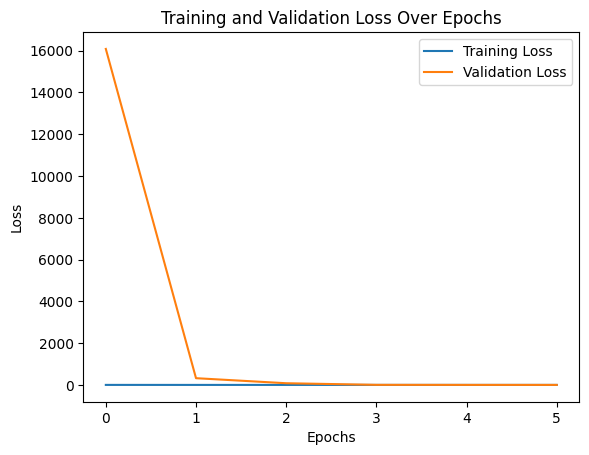

In [11]:
import matplotlib.pyplot as plt

# Assuming you have the training history stored in the variable 'train_history'

# Plot the training loss
plt.plot(train_history.history['loss'], label='Training Loss')

# Plot the validation loss
plt.plot(train_history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


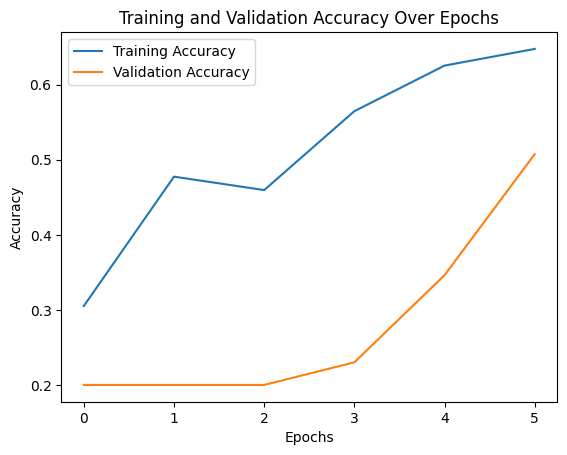

In [12]:
import matplotlib.pyplot as plt

# Assuming you have the training history stored in the variable 'train_history'

# Plot the training accuracy
plt.plot(train_history.history['accuracy'], label='Training Accuracy')

# Plot the validation accuracy
plt.plot(train_history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the true labels and predicted labels for the test set
true_labels = test_set.classes

# Ensure that model.predict returns a NumPy array
predicted_probs = model.predict(test_set)
if isinstance(predicted_probs, list):
    # Concatenate the predictions from multiple branches (assuming main branch is the first)
    predicted_probs = np.concatenate(predicted_probs, axis=1)

# Convert predicted probabilities to class indices
predicted_labels = predicted_probs.argmax(axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


NameError: name 'test_set' is not defined

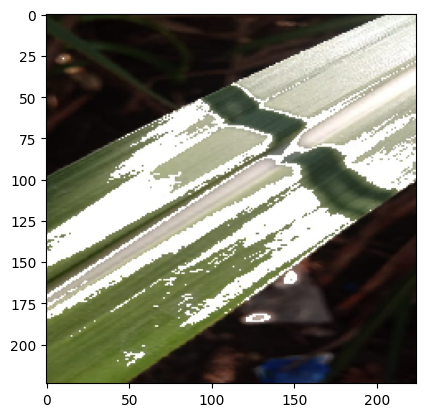

In [13]:
import matplotlib.pyplot as plt

# Display the first image in the batch
plt.imshow(images[0])
plt.show()


# Constraints

In [14]:
# Extract a batch of images from your dataset
images, _ = next(val_set)

# Measure inference time for making predictions
start_time = time.time()

# Assuming your model is named 'model' and you want predictions for the batch of images
predictions = model.predict(images)

end_time = time.time()

# Calculate and print the inference time
inference_time = end_time - start_time
print(f"Inference Time: {inference_time:.4f} seconds")

Inference Time: 0.2928 seconds


In [15]:
def get_model_size(model):
    # Save the model to a temporary file
    model.save('temp_model.h5')

    # Get the size of the saved model file
    model_size = os.path.getsize('temp_model.h5')

    # Remove the temporary file
    os.remove('temp_model.h5')

    return model_size

# Load your model
model = tf.keras.models.load_model(r'D:\New_Fourth_Year\projectDesignGit\sugarcaneSeverityLevel\ResNet18\ResNet18-2024-01-07-11-29-39.h5')

# Get the size of the model
model_size_bytes = get_model_size(model)

# Convert bytes to megabytes for better readability
model_size_megabytes = model_size_bytes / (1024 * 1024)

print(f"Model Size: {model_size_megabytes:.2f} MB")


Model Size: 132.14 MB


In [16]:
model = tf.keras.models.load_model(r'D:\New_Fourth_Year\projectDesignGit\sugarcaneSeverityLevel\ResNet18\ResNet18-2024-01-07-11-29-39.h5')
# Assuming you have a test set generator
test_set = val_set  # Define or load your test set generator

# Use model.evaluate to get accuracy and other metrics
results = model.evaluate(test_set, verbose=1)  # Set verbose=1 for more information

# 'results' is a list containing the evaluation metrics
accuracy = results[1]  # Index 1 corresponds to the accuracy

# Compute misclassification rate
misclassification_rate = 1 - accuracy

print(f'Misclassification Rate: {misclassification_rate * 100:.2f}%')



15/15 [==============================] - 3s 179ms/step - loss: 16082.2803 - accuracy: 0.2000
Misclassification Rate: 80.00%


In [21]:
# 'results' is a list containing the evaluation metrics
main_accuracy = results[3]  # Index 4 corresponds to the accuracy of the main branch

print(f'Main Branch Accuracy: {main_accuracy:.2%}')


IndexError: list index out of range

In [22]:
from sklearn.metrics import accuracy_score

# Assuming you have the true labels and predicted labels for the test set
true_labels = test_set.classes

# Ensure that model.predict returns a NumPy array
predicted_probs = model.predict(test_set)
if isinstance(predicted_probs, list):
    # Concatenate the predictions from multiple branches (assuming main branch is the first)
    predicted_probs = np.concatenate(predicted_probs, axis=1)

# Convert predicted probabilities to class labels
predicted_labels = predicted_probs.argmax(axis=1)

# Compute accuracy using sklearn's accuracy_score
accuracy = accuracy_score(true_labels, predicted_labels)

# Compute misclassification rate
misclassification_rate = 1 - accuracy

print(f'Misclassification Rate: {misclassification_rate:.2%}')


Misclassification Rate: 80.00%


In [23]:
def get_flops(model_h5_path):
    session = tf.compat.v1.Session()
    graph = tf.compat.v1.get_default_graph()


    with graph.as_default():
        with session.as_default():
            model = tf.keras.models.load_model(model_h5_path)

            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

            # We use the Keras session graph in the call to the profiler.
            flops = tf.compat.v1.profiler.profile(graph=graph,
                                                  run_meta=run_meta, cmd='op', options=opts)

            return flops.total_float_ops

In [24]:
model_h5_path = r'D:\New_Fourth_Year\projectDesignGit\sugarcaneSeverityLevel\ResNet18\ResNet18-2024-01-07-11-29-39.h5'
# Get and print the FLOPs
flops = get_flops(model_h5_path)
print(f"Number of FLOPs: {flops}")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Number of FLOPs: 11515137
